#  Libraries

In [1]:
import os, csv, re, glob, math, collections, sys, codecs
import xml.etree.ElementTree as ET
from matplotlib import pylab as plt
import matplotlib.pyplot as plot
import pandas as pd
from io import BytesIO
import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import find_peaks
from scipy import stats
from colorama import *
import seaborn as sns; sns.set()

#  Signature finding: application of statistical test (i.e. Kruskal-Wallis) to find the Molecular Weight where groups are more distinct

* Dataset import

In [2]:
samples = pd.read_csv("proteins_dataset_normalized.csv",header=0).drop(columns=['quality', 'diagnosis']) #import normalized profile output
metadata = pd.read_csv("good_dataset.csv",header=0) #import sample metadata
merged_samples_metadafa = metadata[['Sample','Gender', 'Age group']].merge(samples, how ='inner', on='Sample').set_index('Sample') #Merging Metadata with prints
merged_samples_metadafa.to_csv('dataset.csv')

In [3]:
#transforming data to seaborn plot table
file1 = open('dataset.csv', 'r')
Lines = file1.readlines()

outfile = open('profile_plot.csv', 'w')
outfile.write('Sample,Molecular Weight,Fluorescence,Gender,Age group\n')

header = Lines[0].strip().split(',')
mws = header[3:]

for line in Lines[1:]:
    line_info = line.strip().split(',')

    id = line_info[0]
    gender = line_info[1]
    age = line_info[2]
    fl = line_info[3:]

    ix = 0
    for mw in mws:
        outfile.write(id + ','+ mws[ix]+','+fl[ix] +','+gender+','+age+'\n')
        ix += 1

outfile.close()

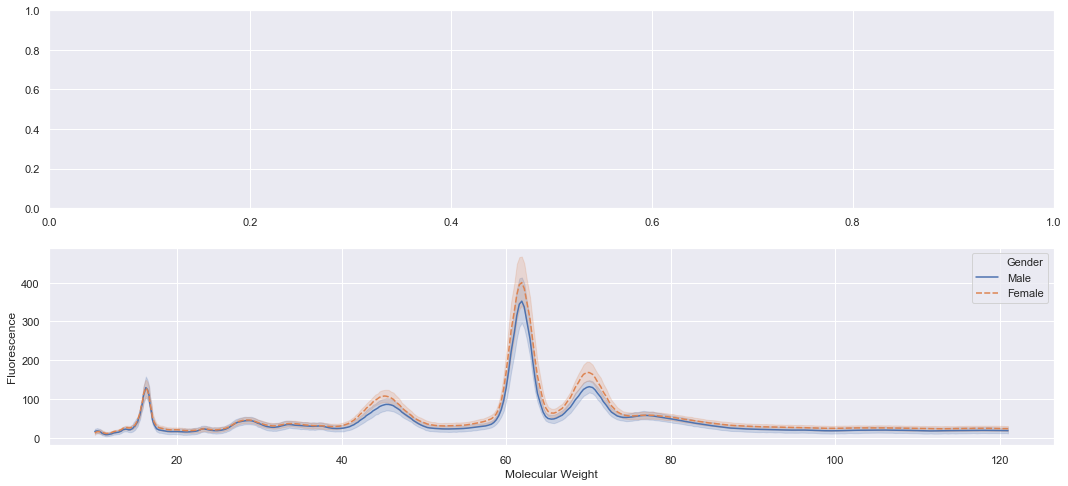

In [4]:
sb_plot = pd.read_csv("profile_plot.csv", header=0) #Dataset for ploting profiles using seaborn
sns.set(style="darkgrid")
fig, axes = plt.subplots(2, 1, figsize=(18, 8))
profile_gender = sns.lineplot(x="Molecular Weight", y="Fluorescence",
             hue="Gender", style="Gender",
            data=sb_plot);

## Statistics
Assumptions to define the test:

Normality
    * Caveat to this is, if group sizes are equal, the F-statistic is robust to violations of normality

Homogeneity of variance
    * Same caveat as above, if group sizes are equal, the F-statistic is robust to this violation
    
Independent observations

### Gender variable analysis

In [5]:
gender_mw = metadata[['Sample','Gender']].merge(samples, how ='inner', on='Sample').drop(columns='Sample') #Merging Metadata with Prints
# gender = stat.drop(columns='Sample')
# stat1.to_csv('kruskal.csv')
gender_mw.head(1)

,Gender,10,10.1,10.2,10.3,10.4,10.6,10.7,10.8,10.9,...,117.2,117.7,118.1,118.6,119,119.5,119.9,120.3,120.8,121
0,Male,0.0,2.461988,4.043012,4.703331,4.625283,4.197604,3.894371,3.977765,4.357224,...,25.335005,25.308718,25.235945,25.151245,25.111653,25.071521,24.964326,24.857882,24.709896,24.58132


In [6]:
grouped_gender_mw = gender_mw.groupby('Gender') # Define the gender group
for name, group in grouped_gender_mw: #Loop to create the groups and get the mw to perform the statistical analysis on all columns
    g1 = gender_mw[(gender_mw['Gender'] == 'Female')]
    g2 = gender_mw[(gender_mw['Gender'] == 'Male')]
    # print(name)
    # print(group)
mw_gender = list(group.columns)
mw_gender.remove('Gender')

In [7]:
import researchpy as rp
rp.summary_cont(gender_mw.groupby('Gender'))

10                                                      10.1  \
         N       Mean         SD        SE 95% Conf.   Interval    N   
Gender                                                                 
Female  42  11.944907  15.847001  2.445245  7.152226  16.737588   42   
Male    24  16.283640  16.516831  3.371484  9.675532  22.891749   24   

                                        ...      120.8                       \
             Mean         SD        SE  ...         SD        SE  95% Conf.   
Gender                                  ...                                   
Female  13.707053  14.373659  2.217904  ...  21.694316  3.347506  17.004226   
Male    16.924400  15.804832  3.226148  ...  19.318235  3.943318  10.616243   

                  121                                                        
         Interval   N       Mean         SD        SE  95% Conf.   Interval  
Gender                                                                       
Female  30.126448  42  23.331910  21.739200  3.354431  16.757224  29.906595  
Male    26.074050  24  18.145044  19.365636  3.952994  10.397176  25.892912  

[2 rows x 2370 columns]

* Levene test
test the homegenity of variances

In [8]:
L = []
for e in mw_gender:
    levene = stats.levene(g1[e], g2[e])
    # print(levene)
    L.append(levene)
levene_test = pd.DataFrame(L)
levene_test['MW'] = mw_gender
levene_test=levene_test[['MW','statistic','pvalue']].round(3)
levene_test.loc[levene_test['pvalue'] >= 0.05]

,MW,statistic,pvalue
0,10,0.132,0.718
1,10.1,0.267,0.607
2,10.2,0.603,0.440
3,10.3,1.126,0.293
4,10.4,1.029,0.314
...,...,...,...
390,119.5,1.474,0.229
391,119.9,1.482,0.228
392,120.3,1.463,0.231
393,120.8,1.460,0.231


* Normality test: D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality.

In [9]:
N1 = [] #normality test for group 1
for e in mw_gender:
    normality = stats.normaltest(g1[e])
    N1.append(normality)
norm_test = pd.DataFrame(N1)
norm_test['MW'] = mw_gender
norm_test=norm_test[['MW','statistic','pvalue']].round(3)
# norm_test.head()

In [10]:
N2 = [] #normality test for group 2
for e in mw_gender:
    normality = stats.normaltest(g2[e])
    N2.append(normality)
norm_test = pd.DataFrame(N2)
norm_test['MW'] = mw_gender
norm_test=norm_test[['MW','statistic','pvalue']].round(3)
# norm_test.head()

In [11]:
# diff = g1 - g2
# diff.plot(kind= "hist")
# plt.xlabel("Length (cm)")
# plot.hist(levene_test['statistic']); #box plots to levene test

* Independent t-test Mann Whitney non-parametric

In [43]:
T = []
for e in mw_gender:
    ttest = stats.mannwhitneyu(g1[e], g2[e], use_continuity=True, alternative='two-sided')
    T.append(ttest)
t_test = pd.DataFrame(T)
t_test['Molecular Weight'] = mw_gender
t_test=t_test[['Molecular Weight','statistic','pvalue']].round(3)
t_test.to_csv('t_test_MW.csv')
# t_test.loc[t_test['pvalue'] <= 0.05]
for pvalue in t_test:
    if ['pvalue'] <= 0.05:
        print('stat diferent')
    else  ['pvalue'] > 0.05:
        print('not stat different')

SyntaxError: invalid syntax (<ipython-input-43-e59ffd0d9c0a>, line 13)

In [13]:
#transforming t_test_MW data to seaborn plot table
file1 = open('t_test_MW.csv', 'r')
Lines = file1.readlines()

outfile = open('t_test_MW_seaborn.csv', 'w')
outfile.write('Molecular Weight,Statistic Value,Statistical test\n')

header = Lines[0].strip().split(',')
sts = header[2:]
# print(sts)
for line in Lines[1:]:
    line_info = line.strip().split(',')

    mw = line_info[1]
    # print(mw)
    stat = line_info[2:4]
    # print(stat)
    # pv = line_info[2]
    # fl = line_info[3:]

    ix = 0
    for st in sts:
        outfile.write(mw + ',' + stat[ix]  + ',' + sts[ix] + '\n')
        ix += 1

outfile.close()

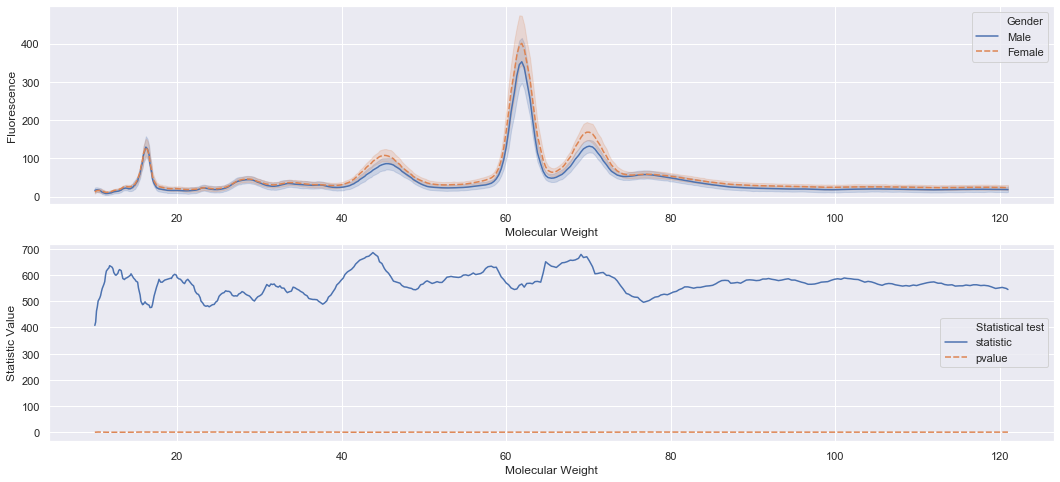

In [14]:
sb_plot = pd.read_csv("profile_plot.csv", header=0) #Dataset for ploting profiles using seaborn
sns.set(style="darkgrid")
fig, axes = plt.subplots(2, 1, figsize=(18, 8))
profile_gender = sns.lineplot(x="Molecular Weight", y="Fluorescence",
             hue="Gender", style="Gender", ax=axes[0],
             data=sb_plot)

ttest_plot = pd.read_csv("t_test_MW_seaborn.csv", header=0)
ttest_pvalue_plot = sns.lineplot(x="Molecular Weight", y="Statistic Value", 
            hue="Statistical test", style="Statistical test",
            ax=axes[1], data=ttest_plot);

### Age group variable analysis

In [15]:
age_group_mw = metadata[['Sample','Age group']].merge(samples, how ='inner', on='Sample').drop(columns='Sample') #Merging Metadata with Prints
age_group_mw.head(1)

,Age group,10,10.1,10.2,10.3,10.4,10.6,10.7,10.8,10.9,...,117.2,117.7,118.1,118.6,119,119.5,119.9,120.3,120.8,121
0,<13,0.0,2.461988,4.043012,4.703331,4.625283,4.197604,3.894371,3.977765,4.357224,...,25.335005,25.308718,25.235945,25.151245,25.111653,25.071521,24.964326,24.857882,24.709896,24.58132


In [16]:
grouped_age_group_mw = age_group_mw.groupby('Age group') # Define the age group
for name, group in grouped_age_group_mw: #Loop to create the groups and get the mw to perform the statistical analysis on all columns
    g1 = age_group_mw[(age_group_mw['Age group'] == '<13')]
    g2 = age_group_mw[(age_group_mw['Age group'] == '13-24')]
    # g3 = age_group_mw[(age_group_mw['Age group'] == '25-50')]
    # print(name)
    # print(group)
mw_age_group = list(group.columns)
mw_age_group.remove('Age group')

* Kruskal-Wallis hypothesis test
    * Null hypothesis (H0): No difference between gender on each molecular weight
    * Alternative hypothesis (HA): There is at least one molecular weght different between genders

In [17]:
K = []
for e in mw_age_group:
    kruskal = stats.kruskal(g1[e], g2[e])
    K.append(kruskal)
kruskal_test = pd.DataFrame(K)
kruskal_test['Molecular Weight'] = mw_age_group
kruskal_test = kruskal_test[['Molecular Weight','statistic','pvalue']].round(3)
# kruskal_test.to_csv('k_test.csv')
# kruskal_test.head()

In [18]:
kruskal_test[kruskal_test.statistic >9]

,Molecular Weight,statistic,pvalue


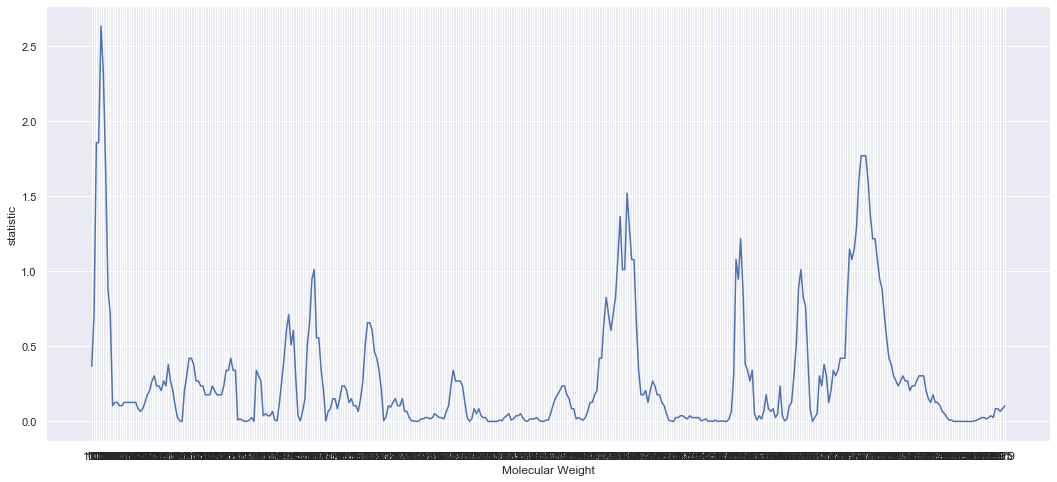

In [19]:
sns.set(style="darkgrid")
# kruksal_plot = pd.read_csv("kruskal_test.csv", header=0)
plt.figure(figsize=(18, 8))
kruskal_plot = sns.lineplot(x="Molecular Weight", y="statistic",  data=kruskal_test);

# Peak presence/abscence analysis

In [21]:
peakdb = pd.read_csv("p_a.csv",header=0).set_index('Presence/Absence') #import peak data table output
peakdb.head(2)

,p_10,p_13,p_15,p_16,p_23,p_27,p_28,p_29,p_30,p_33,...,p_62,p_63,p_68,p_69,p_70,p_71,p_72,p_76,p_77,p_78
Presence/Absence,,,,,,,,,,,,,,,,,,,,,
Absense,63,64,60,7,65,59,44,53,63,53,...,42,63,59,39,46,55,65,57,59,62
Presence,3,2,6,59,1,7,22,13,3,13,...,24,3,7,27,20,11,1,9,7,4


In [22]:
peakdb = pd.read_csv("p_.csv",header=0).drop(columns='sample') #import peak data table output
peakdb.head()

,p_10,p_13,p_15,p_16,p_23,p_27,p_28,p_29,p_30,p_33,...,p_62,p_63,p_68,p_69,p_70,p_71,p_72,p_76,p_77,p_78
0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
4,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [23]:
presence = peakdb[peakdb.loc[:,peakdb.columns] == 1].count()
presence.reset_index(inplace= True)
# presence.to_frame()
# presence.rename(columns={"sample":"Presence/Absence", "0":"Presence"})
# presence = pd.DataFrame()
# a = presence.append(t, ignore_index=False)
absence = peakdb[peakdb.loc[:,peakdb.columns] == 0].count()
presence.head()
# type(presence)

TypeError: Cannot reset_index inplace on a Series to create a DataFrame

In [24]:
presence.append(absence)

NameError: name 'absence' is not defined

In [25]:
peakdb1 = pd.read_csv("p_a.csv"); #import peak data table output
peakdb1.head(2)

,Presence/Absence,p_10,p_13,p_15,p_16,p_23,p_27,p_28,p_29,p_30,...,p_62,p_63,p_68,p_69,p_70,p_71,p_72,p_76,p_77,p_78
0,Absense,63,64,60,7,65,59,44,53,63,...,42,63,59,39,46,55,65,57,59,62
1,Presence,3,2,6,59,1,7,22,13,3,...,24,3,7,27,20,11,1,9,7,4


In [26]:
n_samples = peakdb.sum().values[1]
print(n_samples)

2


In [27]:
title = peakdb.loc[peakdb['Presence/Absence'] == 'Presence/Absence'].columns.tolist()
title.remove('Presence/Absence')
title = np.array(title)
print(title)

KeyError: 'Presence/Absence'

In [28]:
values = peakdb.loc[peakdb['Presence/Absence'] == 'Presence'].values.tolist()[0]
values.remove('Presence')
values = np.array(values, dtype = 'float32')
ix = 0
for element in values:
    # print(element)
    # print(n_samples)
    # print(float(element/n_samples))
    values[ix] = float(element/n_samples)
    ix+=1

print(values)

KeyError: 'Presence/Absence'

In [29]:
indexsorted = np.argsort(values)[::-1]
print(values[indexsorted])

NameError: name 'values' is not defined

In [30]:
print(title[indexsorted])

NameError: name 'title' is not defined

In [31]:
plt.bar(title[indexsorted], values[indexsorted], align='center', alpha=0.5, width=0.9)
plt.xticks(title[indexsorted], rotation='vertical')
plt.show()

NameError: name 'title' is not defined

In [32]:
t1 = pd.read_csv("p_.csv",header=0).set_index('sample') #import peak data table output
t1.head(2)

,p_10,p_13,p_15,p_16,p_23,p_27,p_28,p_29,p_30,p_33,...,p_62,p_63,p_68,p_69,p_70,p_71,p_72,p_76,p_77,p_78
sample,,,,,,,,,,,,,,,,,,,,,
d1122,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
d1127,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


In [33]:
peakdbt = peakdb.T
peakdbt.head(60)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
p_10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
p_13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
p_15,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
p_16,1,0,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
p_23,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
p_27,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
p_28,0,0,1,0,1,0,1,0,0,1,...,0,0,0,0,1,0,0,1,1,1
p_29,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
p_30,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
p_33,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


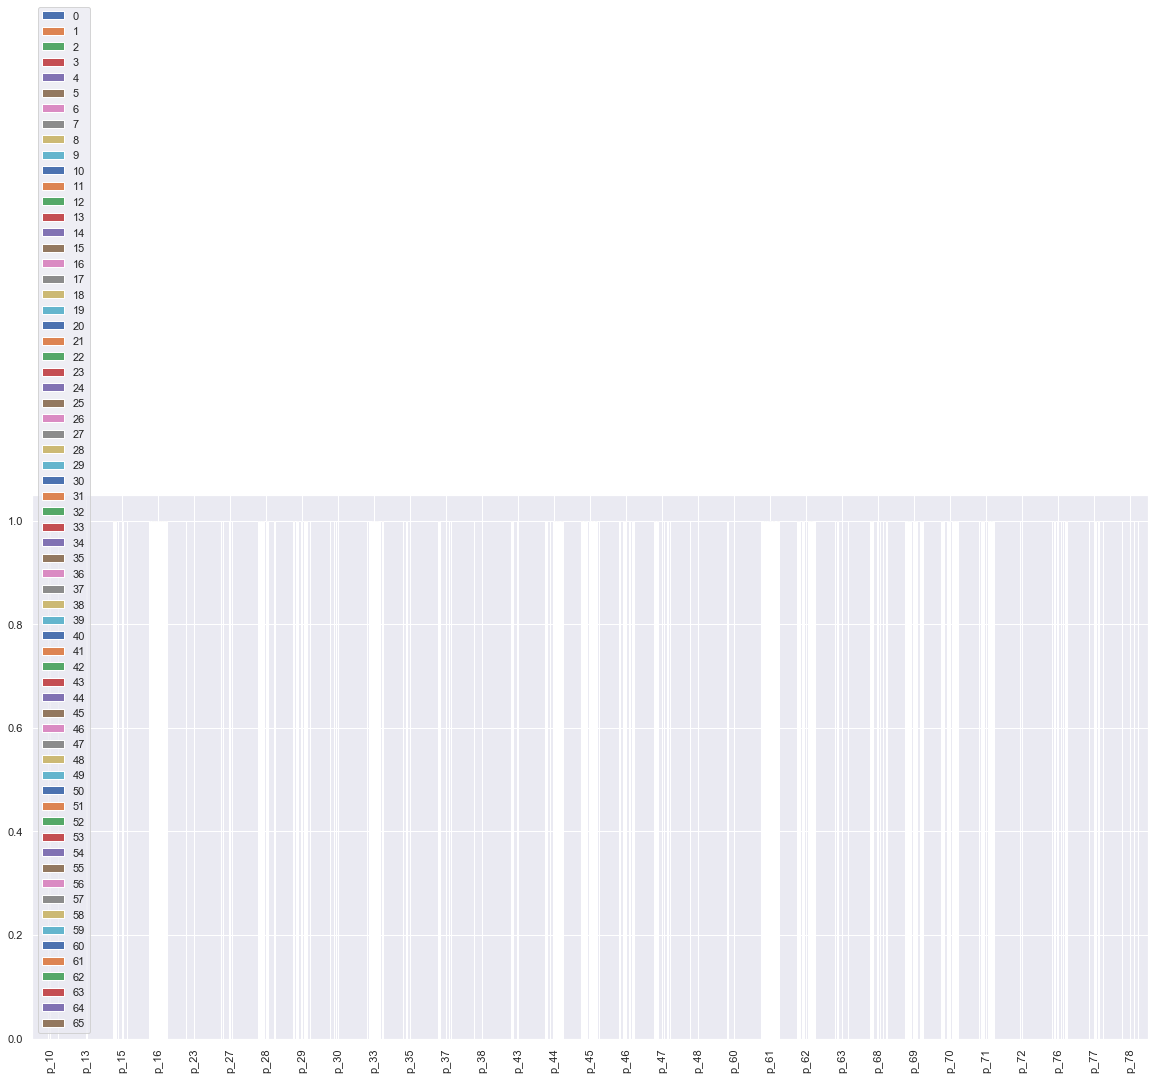

In [34]:
p_hist = peakdbt.plot.bar(figsize=(20,10))

# Peak area analysis

In [35]:
peakdb = pd.read_csv("proteins_peaks_dataset.csv",header=0).set_index('Sample') #import peak data table output
area = metadata[['Sample','Gender','Age group']].merge(peakdb.filter(regex='_area'), how ='inner', on='Sample') #Merging Metadata with Prints
area.head(1)

,Sample,Gender,Age group,p_10_area,p_13_area,p_15_area,p_16_area,p_23_area,p_27_area,p_28_area,...,p_62_area,p_63_area,p_68_area,p_69_area,p_70_area,p_71_area,p_72_area,p_76_area,p_77_area,p_78_area
0,D1122,Male,<13,0.0,0.0,0.0,458.861503,0.0,260.992021,0.0,...,0.0,0.0,0.0,1612.612159,0.0,0.0,0.0,0.0,0.0,0.0


## Gender variable analysis

In [36]:
gender_peak = metadata[['Sample','Gender']].merge(peakdb.filter(regex='_area'), how ='inner', on='Sample').drop(columns=['Sample'])
grouped_gender_peak = gender_peak.groupby('Gender')
for name, group in grouped_gender_peak: #Loop to create the groups and get the mw to perform the statistical analysis on all columns
    g1 = gender_peak[(gender_peak['Gender'] == 'Female')]
    g2 = gender_peak[(gender_peak['Gender'] == 'Male')]
    # print(name)
    # print(group)
p_areas_gender = list(group.columns)
p_areas_gender.remove('Gender')

In [37]:
T = []
for e in p_areas_gender:
    ttest = stats.mannwhitneyu(g1[e], g2[e])
    T.append(ttest)
t_test = pd.DataFrame(T)
t_test['Peak'] = p_areas_gender
t_test=t_test[['Peak','statistic','pvalue']].set_index('Peak').round(3)
# t_test.loc[t_test['pvalue'] <= 0.01]
t_test.head()

,statistic,pvalue
Peak,,
p_10_area,500.0,0.449
p_13_area,495.5,0.360
p_15_area,496.0,0.421
p_16_area,443.0,0.210
p_23_area,492.0,0.234


## Age group analysis

In [38]:
age_group_peak = metadata[['Sample','Age group']].merge(peakdb.filter(regex='_area'), how ='inner', on='Sample').drop(columns=['Sample']) #Merging Metadata with Prints

In [39]:
grouped_age_group_peak = age_group_peak.groupby('Age group')
for name, group in grouped_age_group_peak: #Loop to create the groups and get the mw to perform the statistical analysis on all columns
    g1 = age_group_peak[(age_group_peak['Age group'] == '<13')]
    g2 = age_group_peak[(age_group_peak['Age group'] == '13-24')]
    g3 = age_group_peak[(age_group_peak['Age group'] == '25-50')]
    # print(name)
    # print(group)
p_areas_age_group = list(group.columns)
p_areas_age_group.remove('Age group')

In [40]:
K = []
for e in p_areas_age_group:
    kruskal = stats.kruskal(g1[e], g2[e])
    K.append(kruskal)
kruskal_peak = pd.DataFrame(K)
kruskal_peak['Peak'] = p_areas_age_group
kruskal_peak=kruskal_peak[['Peak','statistic','pvalue']].set_index('Peak').round(3)
kruskal_peak.loc[kruskal_peak['pvalue'] <= 0.05]
# df.to_csv('k_test.csv')
# kruskal_peak.head(31)

,statistic,pvalue
Peak,,
p_28_area,4.151,0.042
